# **Sistema de Controle em Malha Fechada**

O diagrama de blocos abaixo, ilustra o esquema básico de sistemas de controle em malha fechada com realimentação negativa. No esquema, destaca-se $4$ sinais principais:  o sinal de referência $r(t)$, o sinal de erro de controle $e(t)$, o sinal de controle $u(t)$ e o sinal de saída $y(t)$.

Tem-se também, dois sistemas em destaque, o **processo**, representando a dinâmica a ser controlada e o **controlador**. 

Nesse experimento, o objetivo é realizar o projeto, simulação e implementação dos controladores Proporcional (P) e e Proporcional-Integral (PI) para a bancada Motor-gerador.

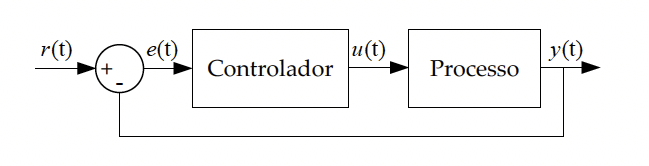

# **Projeto Controlador Proporcional**

<p align = 'justify' > Considera-se que o processo a ser controlado pode ser aproximado por uma sistema de primeira ordem. Ainda que saibamos que a bancada é formada de pelo menos três dinâmicas de primeira ordem em cascata (Motor + Gerador + Filtro RC). </p> 

<p align = 'justify' >A Função de Transferência de Malha Aberta ("Processo") do sistema Motor-Gerador sendo de primeira ordem:</p> 

$$ G(s) = \frac{K_m}{\tau s + 1} \tag{1}$$


Admita que $G_c(s)$ representa a função de transferência do controlador. Em malha fechada, representado por, $H(s)$, é 

$$ H(s) = \frac{G_c(s) G(s)}{1 + G_c(s) G(s)} \tag{2}$$

Considerando $G_c(s) = K_p$, a Função de Transferência de Malha Fechada, com controlador proporcional, é:

$$ H(s) = \frac{K_p G(s)}{1 + K_p G(s)} \tag{3}$$


Substituindo $G(s)$ em $H(s)$, ou seja, (1) em (2): 
$$ H(s) = \frac{ \frac{K_p K_m}{1 + K_p K_m} }{ \frac{\tau}{1 + K_p K_m}s +1 } \tag{4}$$

Observa-se que, tanto o ganho quanto a constante de tempo do sistema em malha fechada são funções do ganho proporcional do controlador. Isso permite projetar o ganho do controlador ($K_p$) de tal forma que o sistema em MF responda a fim de atender critérios de desempenho especificados.



[A biblioteca em python de sistemas de controle pode ser acessa aqui!](https://python-control.readthedocs.io/en/latest/intro.html)

Por exemplo, é possível projetar o ganho do controlador ($K_p$) com o objetivo de tornar a resposta do sistema em MF "mais" rápida. No entanto, considere as seguintes observações:

1. Resposta mais rápida, implica que a constante de tempo do sistema em MF deve ser menor do que a constante de tempo em MA. O quanto menor ?

2. O $K_p$ também altera o ganho DC do sistema em MF. 

3. O controlador proporcional não altera o tipo do sistema. Se o sistema em MA for do tipo $0$, o sistema em malha fechada com  controlador proporcional permanence sendo do tipo ZERO. Explique.

4. O erro em regime permanente para sistema do Tipo $0$, com controlador proporcional, é não nulo. Explique.

Para fins de simulação, vamos considerar os seguintes parâmetros para o sistema em MA: $K_m = 0.2$ e $\tau = 0.3$.

Desse forma, vamos adotar como especificações de desempenho de MF, os seguintes critérios:

1. Constante de tempo de MF ser $70\%$ da constante de malha aberta.  $$ \tau_{MF} = 0,7 \tau $$

Substituindo em $(4)$, tem-se: 

$$ \frac{7}{10} = \frac{1}{1 + K_p K_m}$$

$$ K_p = \frac{ \big(\frac{10}{7} - 1 \big )}{K_m} = 2.1428  $$


Ganho DC do sistema em Malha fechada com controlador proporcional

$$\text{Ganho DC: = } \frac{K_p K_m}{1 + K_p K_m}$$

In [61]:
#___________Código para Calcular o Kp _______#

Km = 0.1887
tau = 0.1675

perc = 7/10

Kp = (1/perc - 1)/Km

print("\nGanho Proporcional: ", Kp)

Ganho = (Km*Kp)/(1+Kp*Km)

print("Ganho DC: ", Ganho)


Ganho Proporcional:  2.255639097744361
Ganho DC:  0.3


# **Simulação do Sistema em Malha Fechada**

In [62]:
# !pip install control -q

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
from scipy.signal import square
from control.matlab import *

%config InlineBackend.figure_format='retina'

### Dados do ensaio

In [64]:
dados = pd.read_csv("../dados/piano_Onda_Quadrada_Exemplo.csv", header = None).values
dados

# Dados do ensaio
tempo_ensaio = dados[0, :]
sinal_entrada_ensaio  = dados[1, :]
sinal_saida_ensaio = dados[2, :]
toc_ensaio = dados[3, :]

# Define janela que despreza os primeiros instantes do ensaio
janela_ensaio = (tempo_ensaio>2) & (tempo_ensaio<14)

# Obtendo o nível DC da entrada
nivel_dc_entrada_ensaio = np.mean(sinal_entrada_ensaio[janela_ensaio])

# Obtendo o nível DC da saída
nivel_dc_saida_ensaio = np.mean(sinal_saida_ensaio[janela_ensaio])

# Remove Nivel DC da Entrada e da Saída
r_ensaio = sinal_entrada_ensaio - nivel_dc_entrada_ensaio
y_ensaio = sinal_saida_ensaio - nivel_dc_saida_ensaio


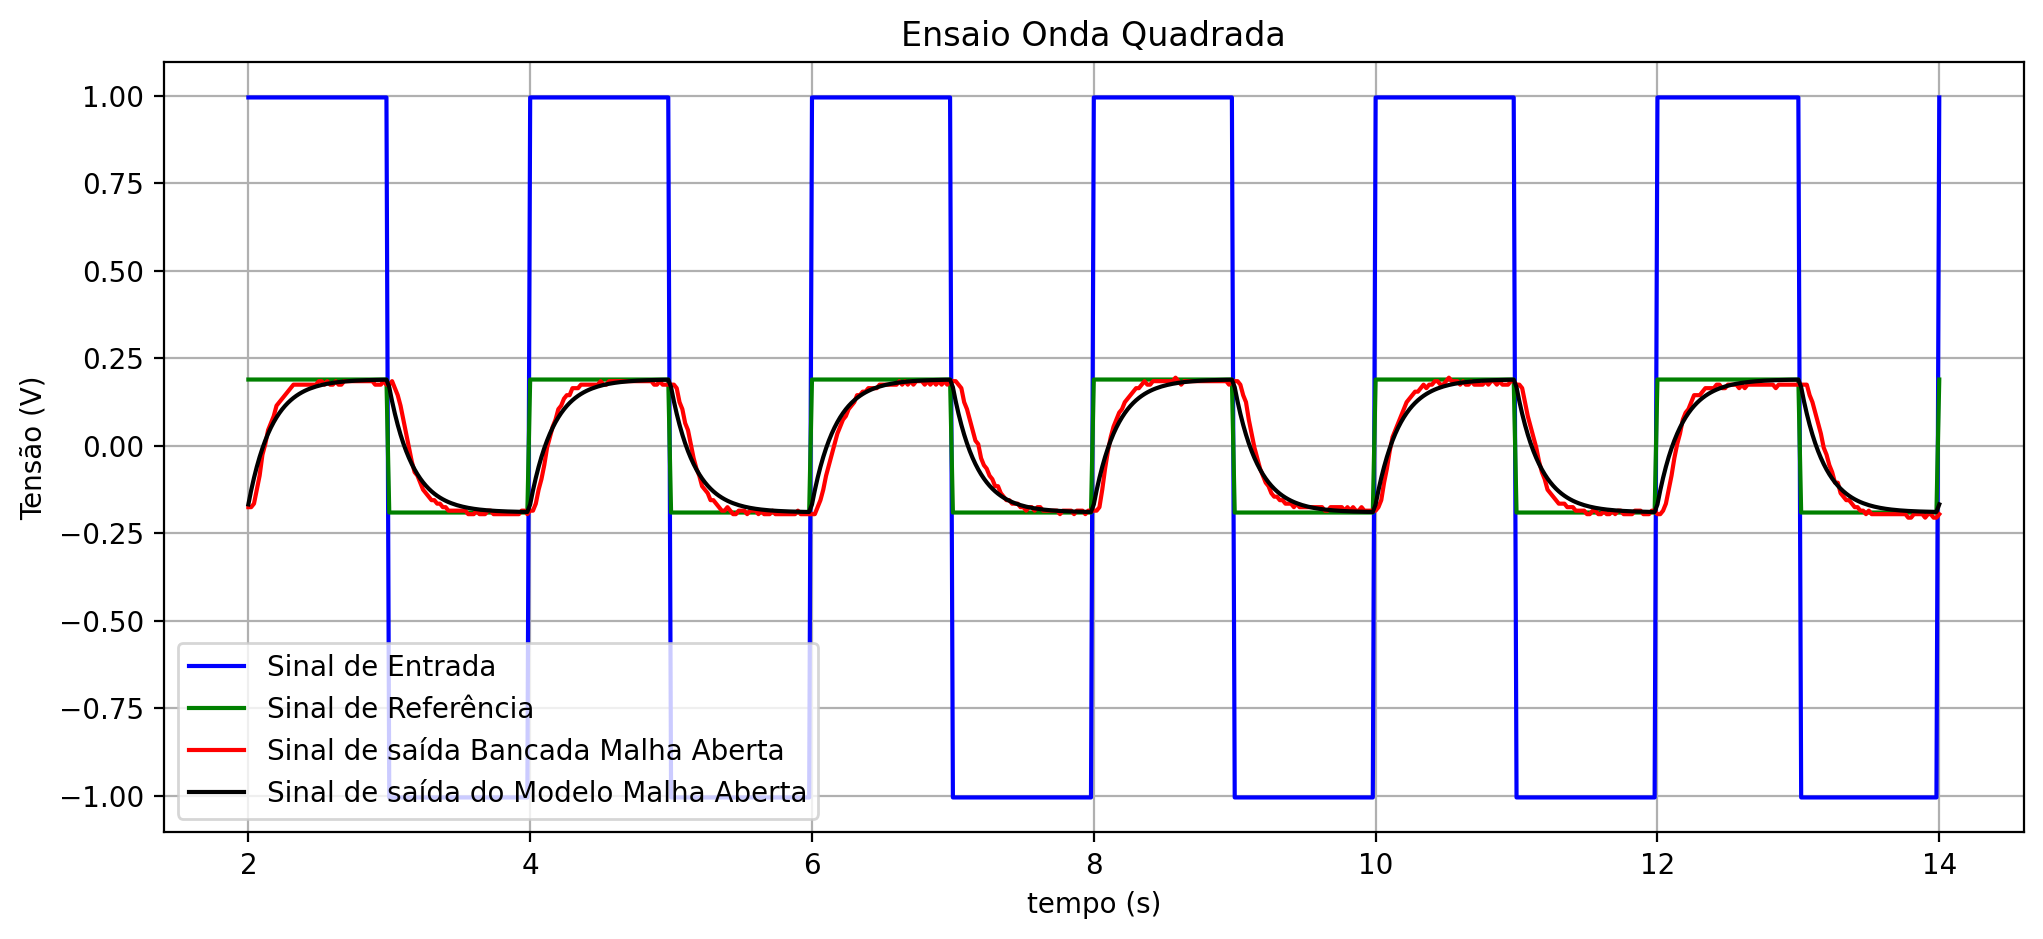

In [65]:
sinal_referencia = 0.19*r_ensaio

num = [Km]
den = [tau, 1.]

Gs = ct.tf(num, den)
_, saida_modelo_com_dc_ensaio = ct.forced_response(Gs, T=tempo_ensaio, U=sinal_entrada_ensaio)

# Tirando a média para subtrair o Nível DC do modelo
nivel_dc_modelo_ensaio = np.mean(saida_modelo_com_dc_ensaio[janela_ensaio])
saida_sem_dc_modelo_ensaio = saida_modelo_com_dc_ensaio[janela_ensaio] - nivel_dc_modelo_ensaio

# Plotagem dos gráficos dos sinais de entrada e saída sem nível DC
plt.figure(figsize=(12, 5))
plt.plot(tempo_ensaio[janela_ensaio], r_ensaio[janela_ensaio], c = 'b',
         label = "Sinal de Entrada")
# plt.plot(tempo_ensaio[janela_ensaio],sinal_referencia[janela_ensaio], c = 'g',
#          label = "Sinal de Referência")
plt.plot(tempo_ensaio[janela_ensaio], y_ensaio[janela_ensaio], 'r',
         label = "Sinal de saída Bancada Malha Aberta")
plt.plot(tempo_ensaio[janela_ensaio], saida_sem_dc_modelo_ensaio, 'k',
         label = "Sinal de saída do Modelo Malha Aberta")

plt. title('Ensaio Onda Quadrada')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid()
plt.show()

Sistema em Malha Aberta:
 
   0.19
-----------
0.168 s + 1

Sistema em Malha Fechada:
 
    0.4275
---------------
0.168 s + 1.427



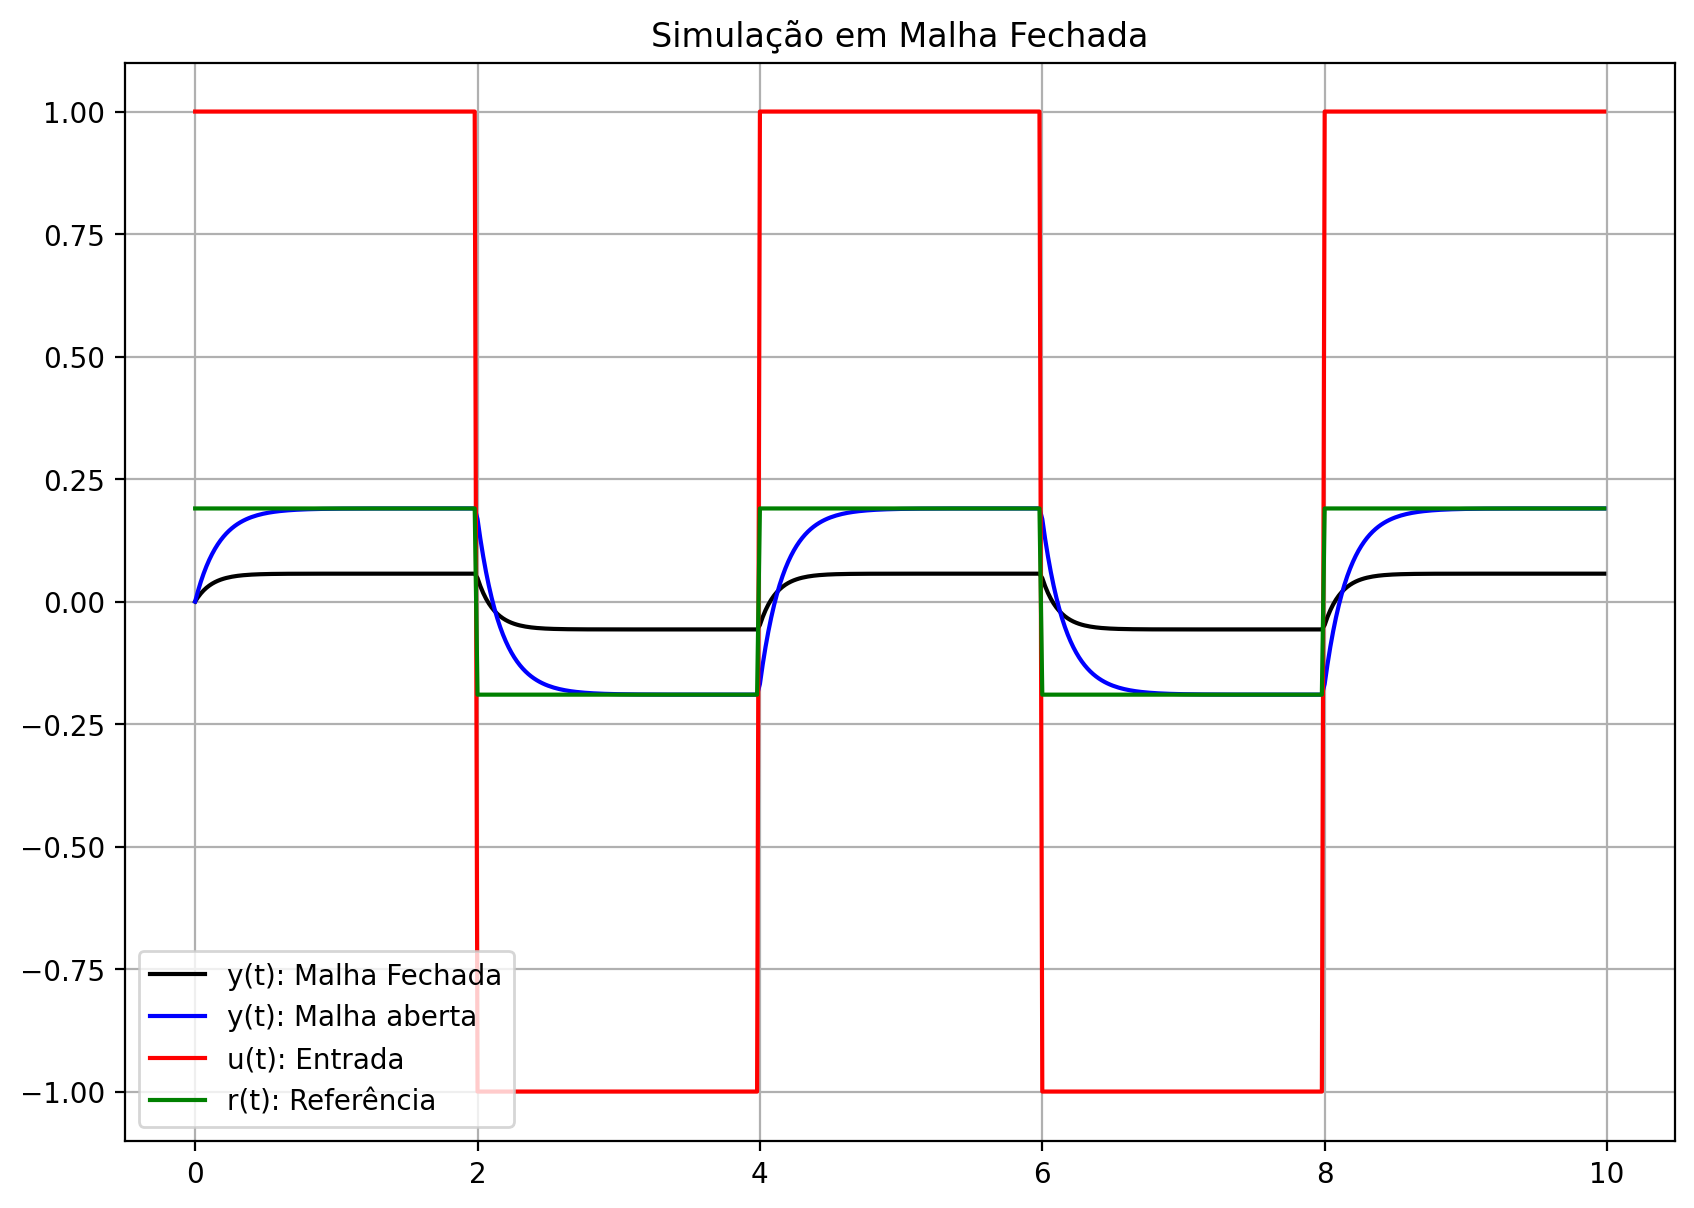

In [66]:
## ________Define o sinal de entrada e sinal de referência __________##
N = 500
Amplutude = 1
freq = 0.25
Fs = 50
Ts =1/Fs

n = np.arange(0, N)
tempo = n*Ts

sinal_de_entrada = Amplutude*square(2*np.pi*freq*n*Ts)

sinal_de_referencia = 0.19*Amplutude*square(2*np.pi*freq*n*Ts)

## ________Sistema em Malha Aberta __________##

NUM = [Km]
DEN = [tau, 1]

G = ct.tf(NUM, DEN)

_, y_malha_aberta = ct.forced_response(G, T = tempo, U = sinal_de_entrada) 

print("Sistema em Malha Aberta:\n", G)

## ________Controlador Propocional __________##

Kp = 2.25
Gc = Kp

## ________Sistema em Malha Fechada __________##

H = ct.feedback(Gc*G, 1, sign = -1)
print("Sistema em Malha Fechada:\n", H)

## ________Simulação do Sistema em Malha Fechada para Onda Quadrada __________##

_, y_malha_fechada = ct.forced_response(H, T = tempo, U = sinal_de_referencia) 

## ________Simulação do Sistema em Malha Fechada para Onda Quadrada __________##

plt.figure(figsize=(10, 7))
plt.plot(tempo, y_malha_fechada, '-k', label = "y(t): Malha Fechada")
plt.plot(tempo, y_malha_aberta, '-b', label ="y(t): Malha aberta")
plt.plot(tempo, sinal_de_entrada, '-r', label ="u(t): Entrada")
plt.plot(tempo, sinal_de_referencia, '-g', label ="r(t): Referência")
plt.title('Simulação em Malha Fechada')
plt.legend()
plt.grid()
plt.show()

# **Exercício de Fixação**

Analise a resposta do sistema em malha fechada com o controlador proporcionale responda:

1. A resposta do sistema em malha fechada é mais rápida do que a resposta em malha aberta?  Explique. 
2. A medida que o ganho $K_p$ assume valores elevados, o polo de malha fechada se afasta do eixo imaginário, no plano complexo. Verdadeiro ou Falso? Explique.
3. O erro em regime permanente está elevado. Sem substituir o tipo de controlador, o que poderia ser alterado (e como) a  fim de reduzir o erro em regime permanente?  Explique quais conseguências são esperadas com essa medida.


# **Sinal de Controle**

Em simulação, pode-se admitir valores elevados para o ganho do controlador, com a finalidade de reduzir o erro em regime permanente. No entanto, quanto maior o valor de $K_p$, maior será a magnitude do sinal de controle.

<p align = 'justify' >Deve-se lembrar que a bancada é alimentada por uma fonte de tensão finita. Logo a magnitude do sinal de controle não deve ser superior a tensão de alimentação da bancada Motor-Gerador. </p>

Para simular o sistema em MF e obter na saída o sinal de controle, deve-se criar um sistema com essa finalidade.

A função *feedback (sys1, sys2, sign = -1)* admite:

1.  O *sys1* função de transferencia de Malha Direta; 
2.  O *sys2* função de transferencia de Realimentação; 
3.  O *sign* sinal da realimentação, para controle deve ser *sign = -1*.


Sendo assim, faz-se: 

1. *sys1* igual a $G_c (s)$
2. *sys2* igual a $G(s)$



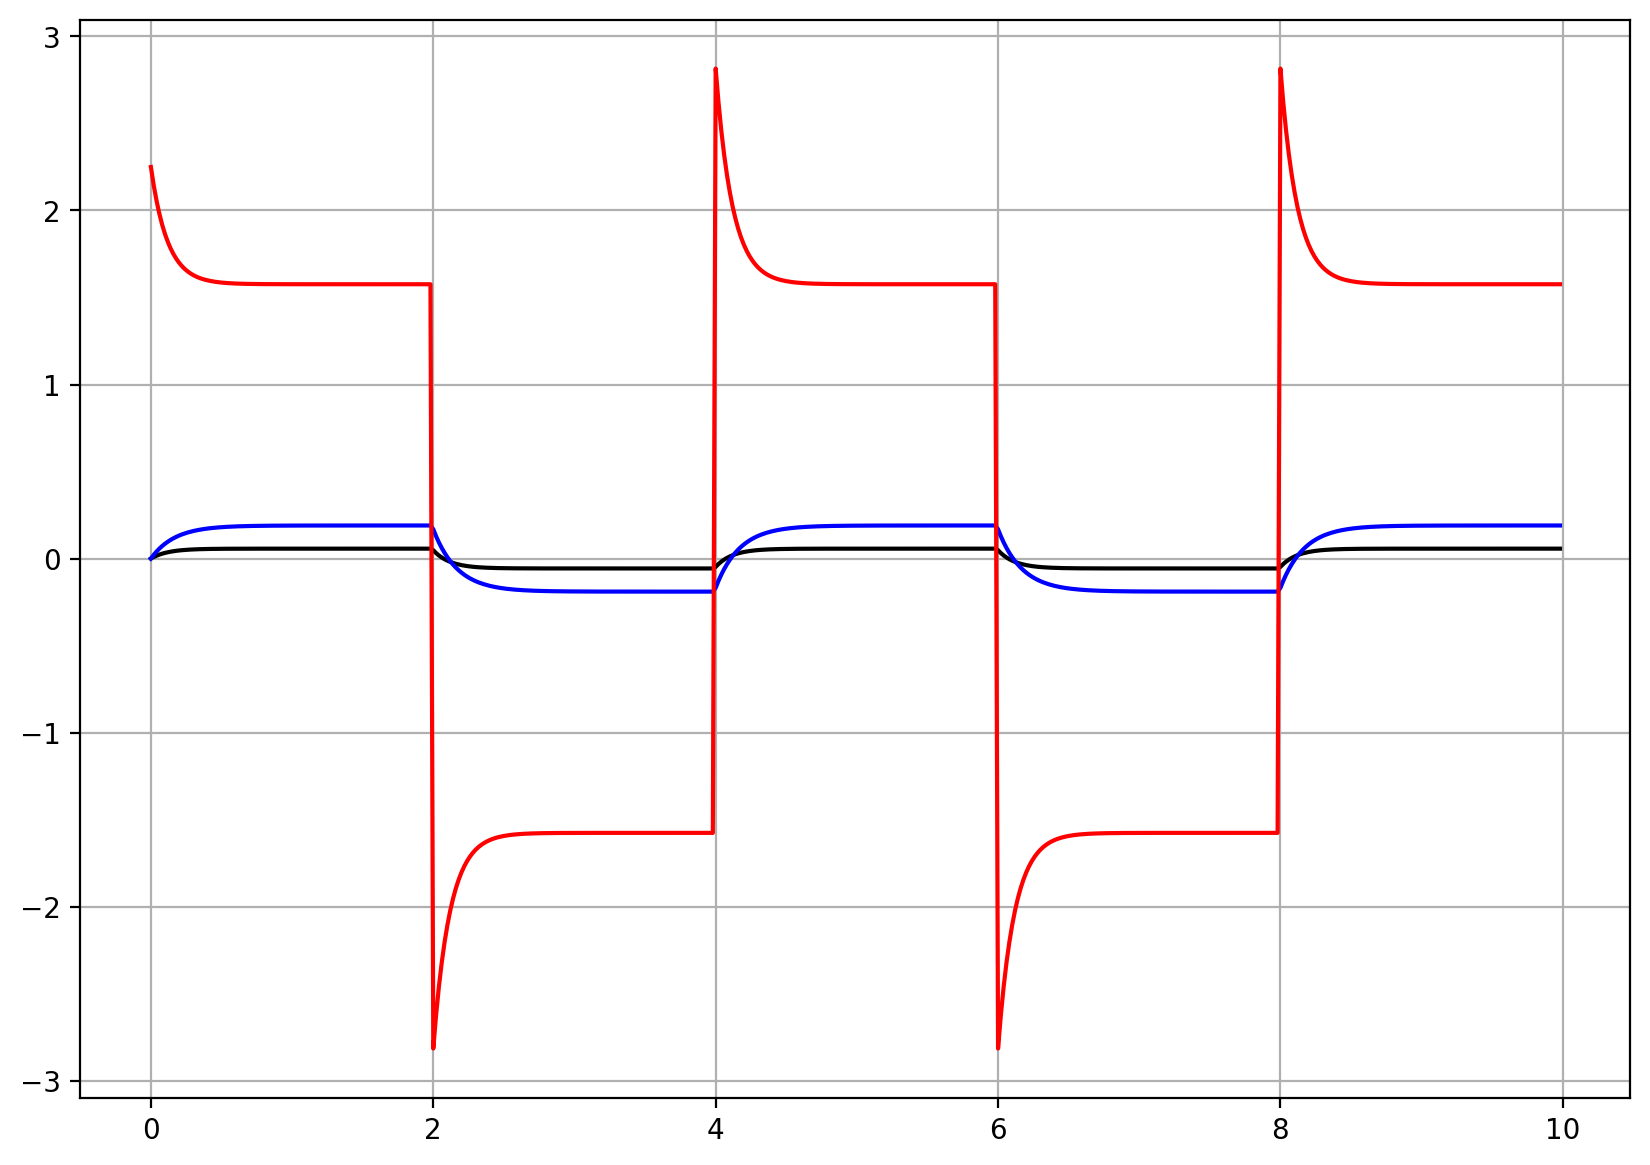

In [67]:
## ________Sistema para Obter Sinal de Controle __________##

C = ct.feedback(Gc, G, sign =-1)

## ________Simulação para obter o Sinal de Controle __________##

_, sinal_controle = ct.forced_response(C, T = tempo, U = sinal_de_entrada)

## ________Simulação do Sistema em Malha Fechada para Onda Quadrada __________##

plt.figure(figsize=(10,7))
plt.plot(tempo, y_malha_fechada, '-k')
plt.plot(tempo, y_malha_aberta, '-b')
plt.plot(tempo, sinal_controle, '-r', label= "Sinal de Controle")
plt.grid()
plt.show()



# **Lugar Geométrico das Raízes - LGR**

Considere $G(s)$ a função de transferência de malha direta em cascata com o controlador $K$, com realimentação unitária e negativa. Em malha fechada, tem-se:

$$ H(s) = \frac{K G(s)}{1+ K G(s)}$$

O LGR corresponde a todos os pontos no plano complexo que as raízes do polinômio do denominador de $H(s)$ pode assumir quando o ganho $K$ varia de zero a infinito. Sendo assim, tem-se:

$$ 1 + K G(s) = 0. \tag{A}$$

Para valores de $K$ positivos, a equação (A) impõe duas restrições sobre o LGR, são elas:

1. $\angle{G(s)} = (2\ell +1)180^{0}$, para $\ell = 0, \pm 1, \pm 2, ...$ 

2. O ganho $K = \frac{1}{| G(s) |}$ 



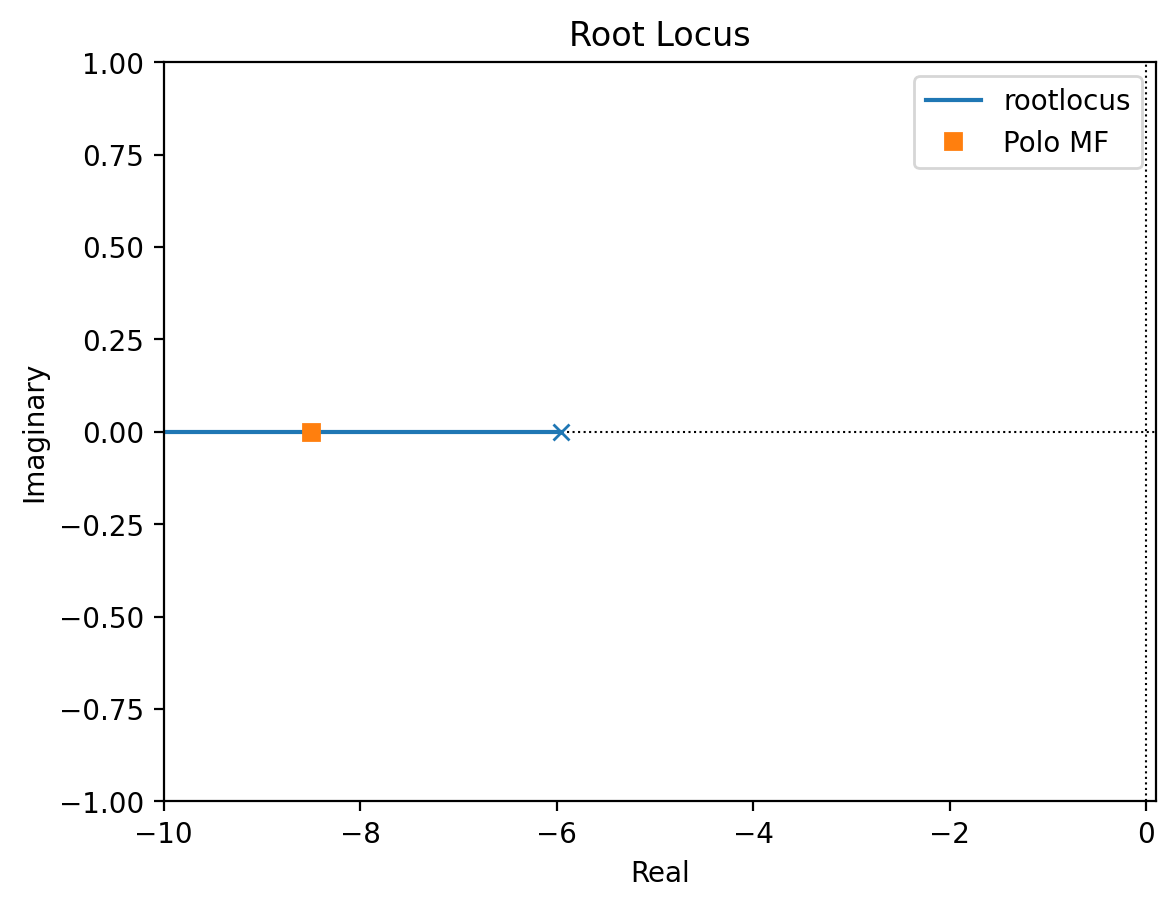

In [68]:
plt.figure()
ct.root_locus(G, xlim =(-10,0.1), ylim = (-1,1), grid = False);
plt.plot(H.pole().real, H.pole().imag, 's', label = 'Polo MF')
plt.legend()
plt.show()

# **Projeto do Controlador PI**

Função de Transferência de malha aberta:

$$ G(s) = \dfrac{K_m}{\tau s + 1} = \dfrac{K  b}{s + b} \tag{A}$$


Em que, 
$K = K_m$ e 
$b = \dfrac{1}{\tau}$

Função de Transferência de Controlador PI:

$$ G_c (s) = \dfrac{K_c (s + a)}{s} \tag{B}$$


Em malha fechada:

$$ H(s) = \dfrac{G_c(s) G(s)}{1 + G_c(s) G(s)} \tag{C}$$


Substituindo ($A$) e ($B$) e ($C$), tem-se 

$$ \dfrac{\dfrac{K_c (s + a)}{s} \dfrac{K  b}{s + b} }{1 + \dfrac{K_c (s + a)}{s} \dfrac{K  b}{s + b}} $$

Resulta em, 

$$
    H(s) =  \dfrac{K_c K b (s + a)}{s(s+b) + K_c K b (s + a)}
$$ 

$$
    H(s) =  \dfrac{K_c K b (s + a)}{s^2 + (b + K_c K b)s + K_c K b a}  \tag{D}
$$

<br>

Com o controlador PI na malha, o tipo do sistema passa a ser Tipo 1 (erro em regime permanente nulo para entrada degrau). 


Os parâmetros $K$ e $b$ são conhecidos a partir do modelo do sistema em malha aberta.

Um abordagem para o projeto do controlador PI consiste em comparar a função de transferência em (D) com uma função de transferência padronizada de referência.

$$
    H_{ref}(s) =  \dfrac{\omega_n^2}{s^2 + 2 \zeta \omega_n s + \omega_n^2 } \tag{E}
$$

em que os polos são parametrizados por $\zeta$ e $\omega_n$.

Assim, as especificações de desempenho do sistema em malha fechada podem ser traduzidas em valores de $\zeta$ e $\omega_n$. Tal que,

1. **Ultrapassagem percentual** ($\% UP$):

$$ 
    \% UP = 100 \times e^{\dfrac{-\zeta \pi}{\sqrt{1-\zeta^2}}} \zeta = \dfrac{-\ln(\% UP / 100)}{\sqrt{\pi^2 + \ln^2(\% UP / 100)}}
$$

2. **Instante de pico**:

$$ 
    T_p = \dfrac{\pi}{\omega_d}
$$

em que $\omega_d = \omega_n \sqrt{1-\zeta^2}$.

3. **Tempo de assentamento**: Instante em que a resposta do sistema alcança e permanence dentro da faixa de $2\%$ em torno do valor de regime permanente.

$$ T_s = \dfrac{4}{\sigma}$$

Para o critério de $1\%$, considere,

$$T_s = \dfrac{4,6}{\sigma}$$

em que  $\sigma = \zeta  \omega_n$.
1. **Tempo de subida**: tempo necessário para que a forma de onda vá de $0.1$ a $0.9$ do valor final.

$$ T_r ≈ \dfrac{1,8}{\omega_n}$$




A Figura (retirado do Frankin and Powell) ilustra a reposta de um sistema de segunda ordem subamortecido. Com destaque para as especificações de desempenho.

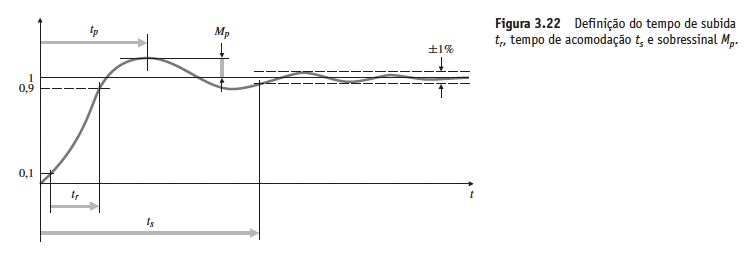

Plano Complexo, com destque para a localização de um par de polos complexos conjugados, parametrizados por $\zeta$ e $\omega_n$.   

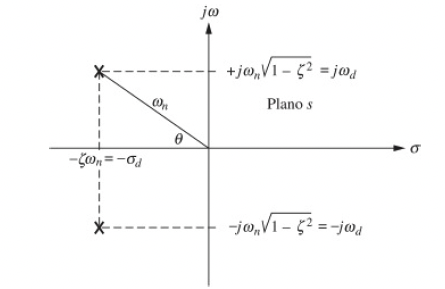

In [69]:
#___________ Especificações de desempenho _________


UP = 5      # Ultrapassagem percentual em %
Ta = 0.55

qsi = -np.log(UP/100)/(np.sqrt(np.pi**2 + np.log(UP/100)**2))

print("Fator de amortecimento: ", qsi)


wn = 4/(qsi*Ta)
print("Frequencia natural: ", wn)

Fator de amortecimento:  0.6901067305598217
Frequencia natural:  10.53855432887542


Ganho do Controlador PI: 
 7.864715789473686 
 Zero do PI: 
 12.39513456503932


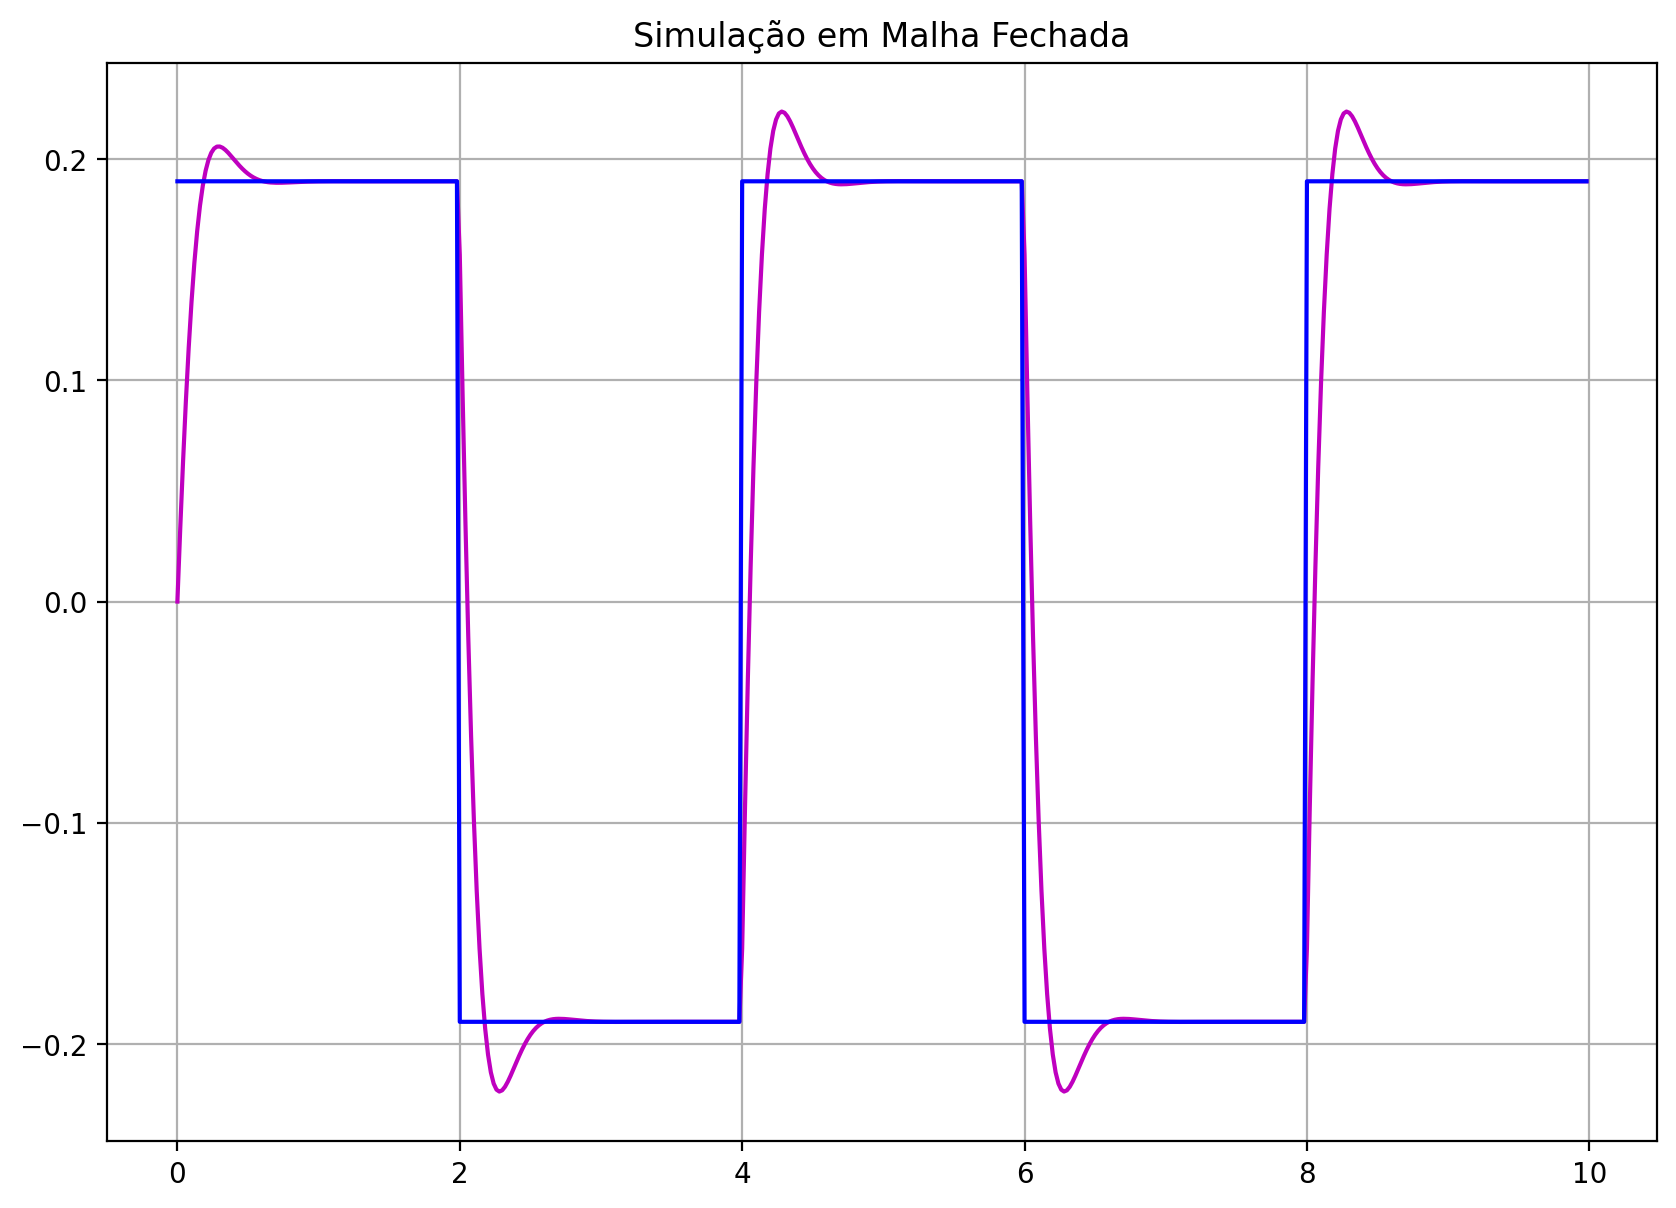

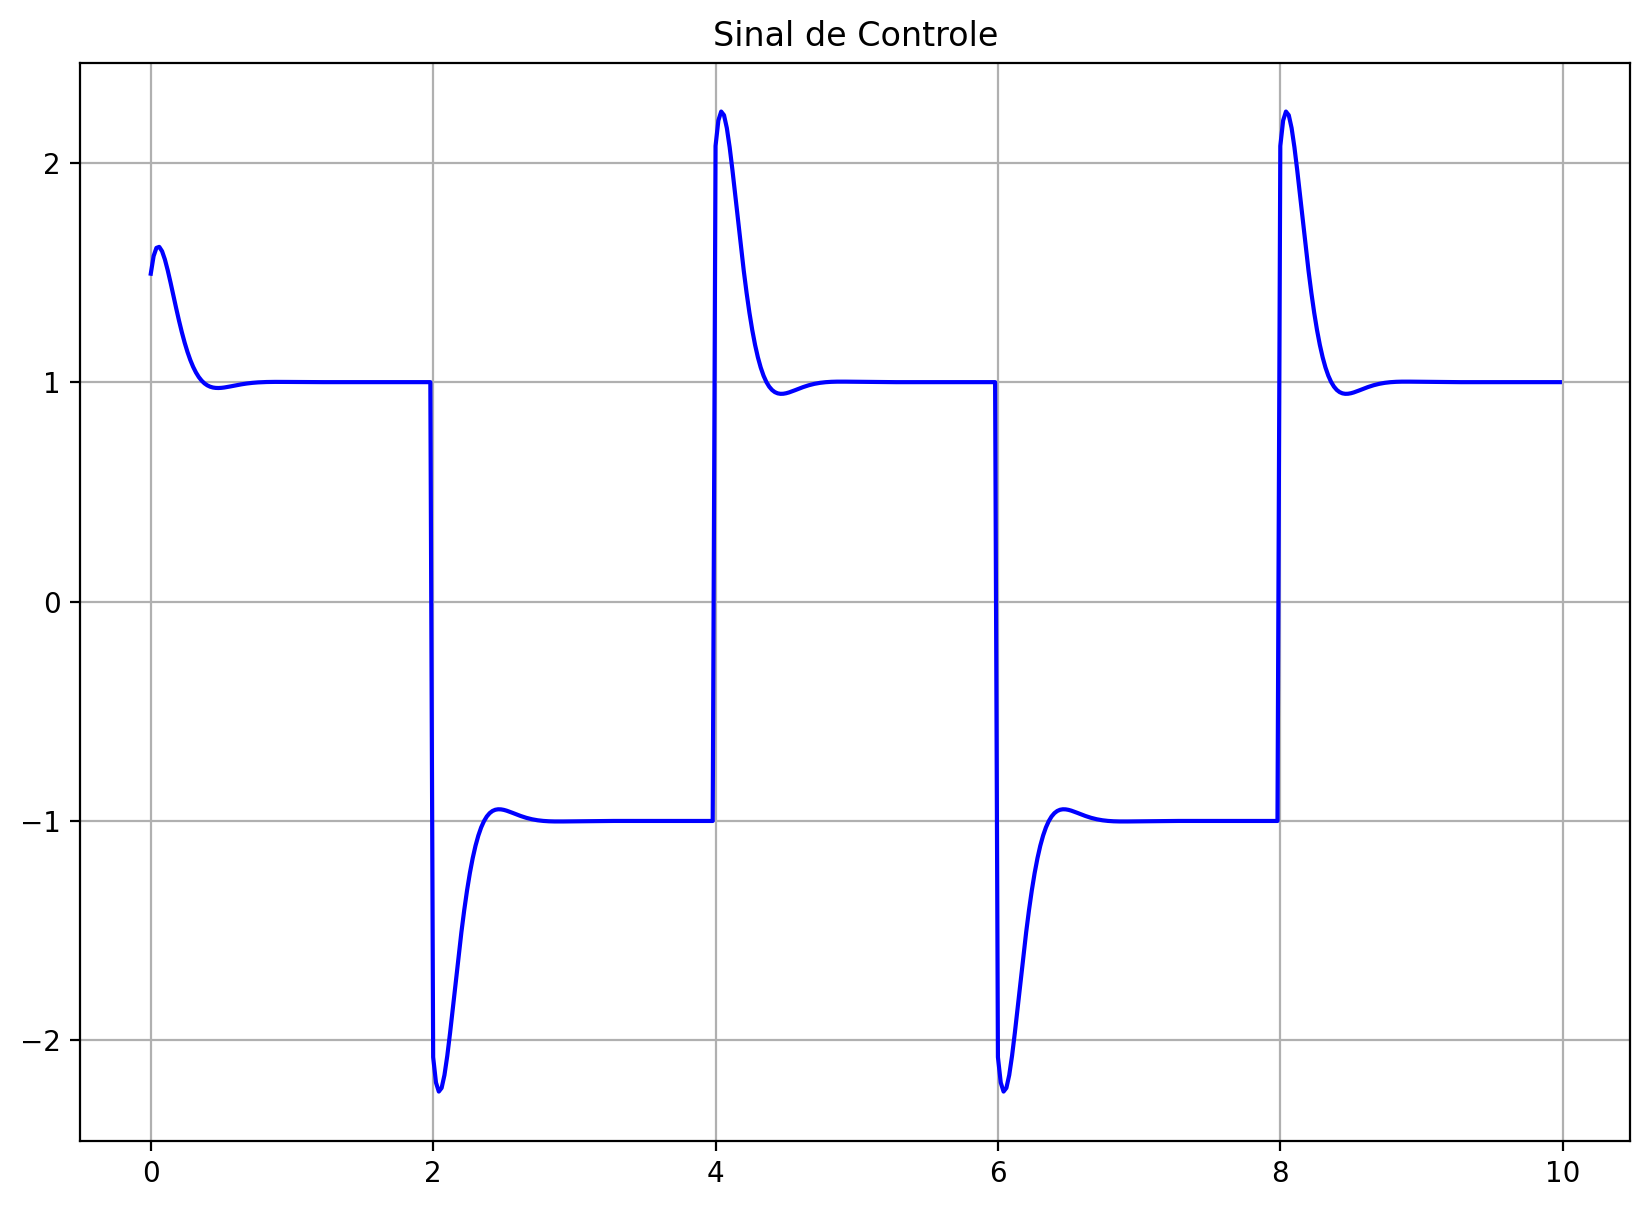

In [70]:
# Fator de Amortecimento
qsi = 0.707

# Freq Natural
wn = 10.5

b = 1/tau
K = Km

Kc = (((2*qsi*wn)/b)-1)/K
a =  (wn**2)/(Kc*K*b)

print('Ganho do Controlador PI: \n', Kc, '\n Zero do PI: \n', a)

# K = 3.57
# a = -24

Gc = ct.tf([Kc*1,Kc*a],[1,0])

H_pi = ct.feedback(Gc*G, 1, sign = -1)

C_pi = ct.feedback(Gc, G, sign = -1)

_,ymf_pi = ct.forced_response(H_pi, T = tempo, U = sinal_de_referencia)
_,u_pi = ct.forced_response(C_pi,T = tempo, U = sinal_de_referencia)

plt.figure(figsize=(10,7))
# plt.plot(tempo,ym,'k' ,tempo,y,'r')
plt.plot(tempo,ymf_pi,'m')
plt.plot(tempo,sinal_de_referencia,'b')
plt.title("Simulação em Malha Fechada")
plt.grid()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(tempo,u_pi,'b')
plt.title("Sinal de Controle")
plt.grid()
plt.show()

Polos de MF: 
 [-7.4235+7.42574224j -7.4235-7.42574224j]


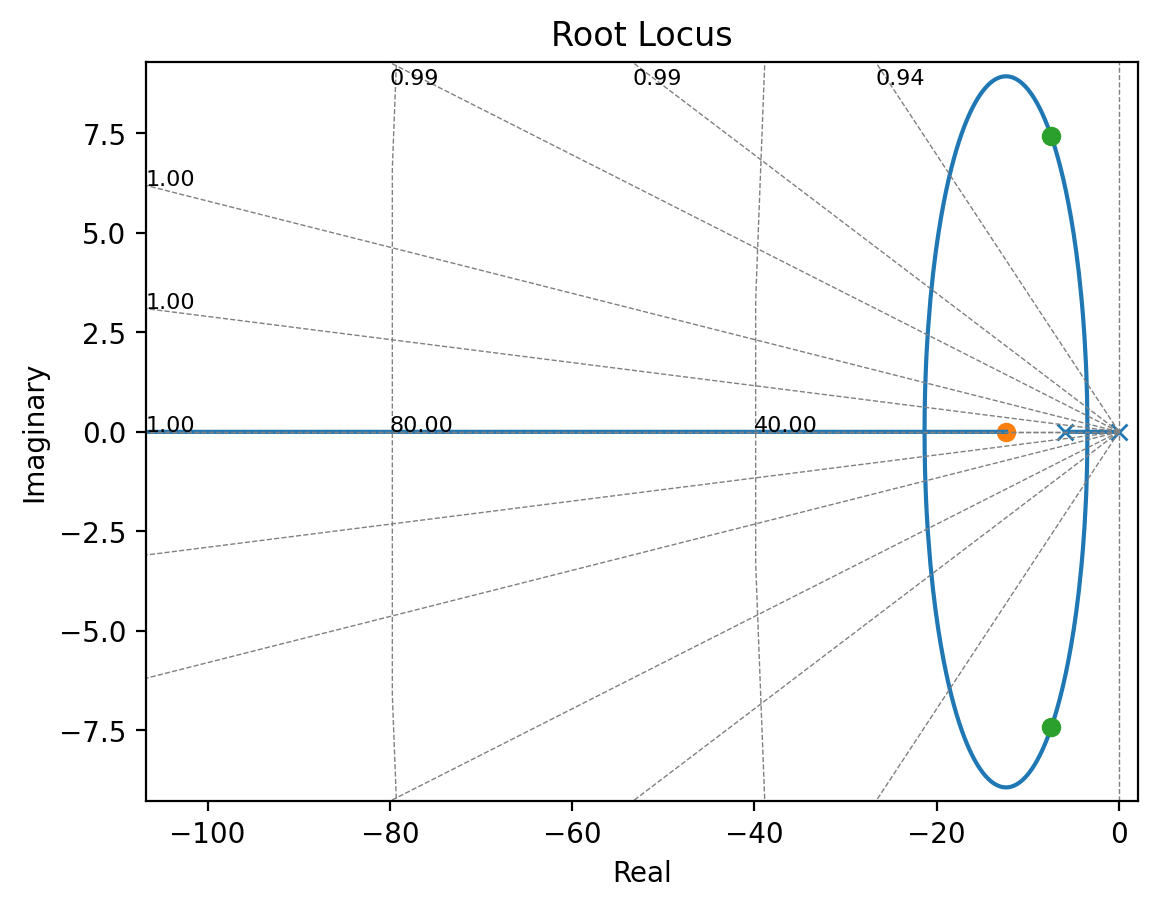

Freq Natural: 
 [10.5 10.5]
Fator de Amortecimento: 
 [0.707 0.707]


In [71]:
ct.rlocus(Gc*G, plot=True, grid = True);
print('Polos de MF: \n', H_pi.pole() )
plt.plot(np.real(H_pi.pole()),np.imag(H_pi.pole()),'o')
plt.show()
print('Freq Natural: \n', np.abs(H_pi.pole()))
print('Fator de Amortecimento: \n', np.cos(np.pi - np.angle(H_pi.pole())))

In [72]:
Gz = ct.c2d(Gc,Ts, 'tustin')

print('Função de Transferência: \n', Gz)

Função de Transferência: 
 
8.84 z - 6.89
-------------
    z - 1

dt = 0.02



$$\frac{U(z)}{E(z)} = \frac{b_0 z + b_1}{z - 1} \frac{z^{-1}}{z^{-1}} $$


Equação de Diferenças:

$$ u(k) = u(k-1) + b_0 e(k) + b_1 e(k-1)$$ 



$$ $$